# Trust Your Tesla
##Collision Course Prediction for Simulated Autonomous Vehicles 
<br>
This notebook contained the concepts and code for Byron Butaney and Kaleb Slater Newman's CSCI 1430 final project.

# Preprocessing

Ultimately, we want the input into our model to be batches of 4-Dimensional tensors of shape $\chi \in \mathbb{R}^{F \times M \times N \times C} $ where *F* denotes the sequence length and each frame is *M*  x *N*  with *C* color channels. The training data is quite large and can cause memory errors, so we need to create a batch generator function to yield the data. We can collect the test and validation data in a standard fashion by loading them from .npz files.



Mount Drive, Install Config, Import Dependencies



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install config

import cv2
import os
import json
import random
from config import *
import numpy as np
import h5py
import tensorflow as tf
import json
import shutil
from collections import deque

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Set Up Configuration

In [ ]:
num_classes = 2
epochs = 12
batch_size = 8

Set Up Directories

In [ ]:
base_folder = os.path.abspath(os.curdir)
data_path = "/content/drive/MyDrive/datasets_h5/"
colab_path = "/content/drive/MyDrive/files"
train_folder = os.path.join(data_path,'train_set')
test_folder = os.path.join(data_path,'test_set')
valid_folder = os.path.join(data_path,'valid_set')
model_folder = os.path.join(colab_path,'nf','model_folder')
tensorboard_folder = os.path.join(colab_path,'nf','tensorboard_folder')
checkpoint_path = os.path.join(model_folder,"model_weights_{epoch:03d}.ckpt")

**<font color="green">Batch generator yield function</font>**

In [ ]:
def batch_generator(data_folder):
        runs = int(batch_size/8)
        data = os.listdir(data_folder)
        item = 0
        random.shuffle(data)
        while item<=len(data):
            sequences=np.empty((0,8,140,210,3))
            labels= np.empty((0,2))
            for phi in range(runs):
                # print(i)
                npz_object = np.load(os.path.join(data_folder,data[item]))
                sequences = np.vstack((sequences,npz_object['name1']/255))
                labels = np.vstack((labels,npz_object['name2']))
                item += 1
                if item>=len(data):
                    item = 0
                    random.shuffle(data)
            yield sequences,labels

**<font color="green">Standard get data function for validation and training</font>**

In [ ]:

def get_split_data(data_folder):
  curr_img = 0
  split_data = os.listdir(data_folder)
  runs = 4

  sequence = np.empty((0,8,140,210,3))
  labels = np.empty((0, 2))
  while (curr_img <= len(split_data)):
    
    for phi in range(runs):
      try:
        np_data = np.load(os.path.join(data_folder, split_data[curr_img]))

        sequence = np.vstack((sequence, np_data['name1']/255))

        labels = np.vstack((labels, np_data['name2']))
        curr_img += 1
        
      except:
        return sequence, labels
        
  return sequence, labels
  

#Model Architecture

This ConvNetwork Class defines our model architecture for this class. <br>

The key to this architecture is the ConvLSTM2D layer. The ConvLSTM unit are governed by the equations: <br>

[1] $ i_t = \sigma(W_{xi} * X_t + W_{hi} * H_{t-1} + W_{ci} \circ C_{t-1} + b_i$ \\

[2] $f_t = \sigma(W_{xf} * X_t + W_{hf} * H_{t-1} + W_{cf} \circ C_{t-1} + b_f)$ \\

[3] $C_t = f_t \circ C_{t-1} + i_t \circ tanh(W_{xc} * X_t + W_{hc} * H_{t-1} + b_c)$ \\

[4] $o_t = \sigma(W_{xo} * X_t + W_{ho} * H_{t-1} + W_{co} \circ C_{t} + b_o)$ \\

[5] $H_t = o_t \circ tanh(C_t)$ \\
$\circ$ Represents the Hadamard product
\\

$*$ Represents convolution \\


For the ConvLSTM2D, the convolution is 2D convolution. These equations can be computed efficiently by concatenating the hidden state and the input, performing 2D convolution, and splittign the output tensor into 4 smaller tensors to perform the operations with the cell state. TensorFlow provides us a function to do this.



Architecture

In [ ]:
class ConvNetwork(tf.keras.Model):
  def __init__(self, num_filters, final_conv_filters):
    super().__init__(self)
    self.num_filters = num_filters
    self.final_conv_filters = final_conv_filters

    self.convlstm = tf.keras.Sequential([
        tf.keras.layers.ConvLSTM2D(self.num_filters, (5,5), padding="same", return_sequences=True, activation="relu", data_format='channels_last'),
    tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization()),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool2D((3,3), padding='same', data_format="channels_last")),
    tf.keras.layers.ConvLSTM2D(self.num_filters, (5,5), padding="same", return_sequences=True, activation="relu", data_format='channels_last'),
    tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization()),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool2D((3,3), padding='same', data_format="channels_last")),
    tf.keras.layers.ConvLSTM2D(self.num_filters, (3,3), padding="same", return_sequences=True, activation="relu", data_format='channels_last'),
    tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization()),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool2D((3,3), padding='same', data_format="channels_last")),
    tf.keras.layers.Conv3D(self.final_conv_filters, (3,3,3), padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.5),   
    tf.keras.layers.Dense(num_classes,activation='softmax')
        
    ])

  def call(self, inputs):
    return self.convlstm(inputs)


In [ ]:
nft_network = ConvNetwork(64,1)

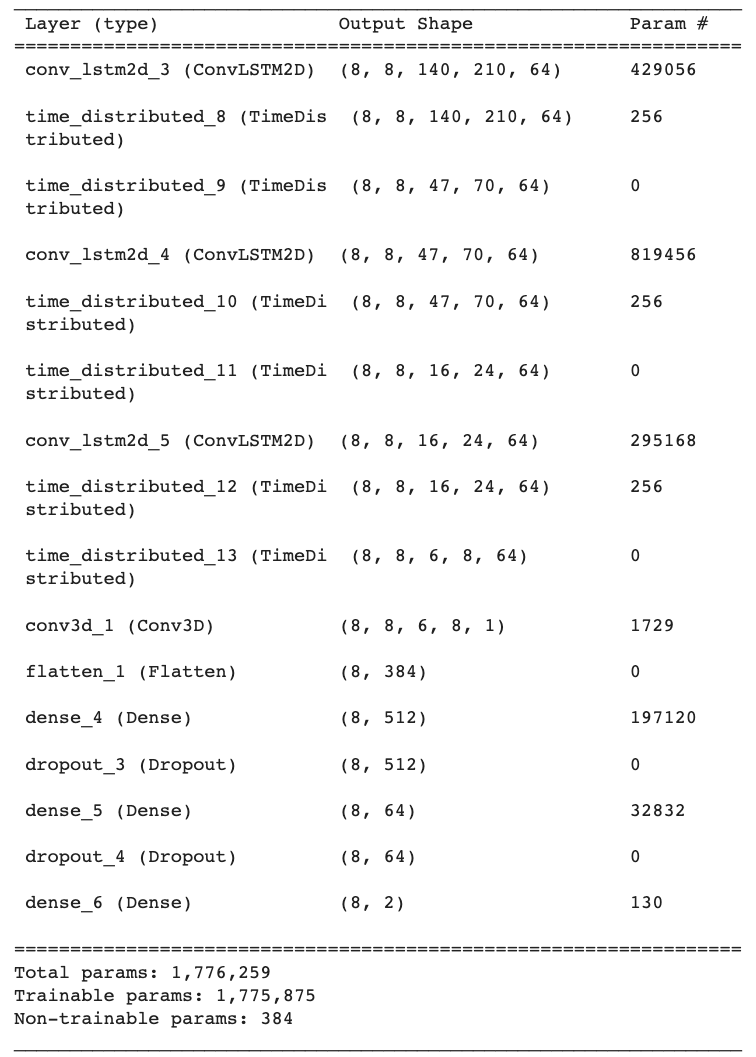

## Other architectures experimented with

1.   List item
2.   List item



In [ ]:
lstm_a = ConvNetwork(64,32)
lstm_b = ConvNetwork(64,24)
lstm_c = ConvNetwork(32,32)

#Training

In [ ]:
# create folders in drive to save weights
if not os.path.exists(model_folder):
    os.makedirs(model_folder)
else:
    shutil.rmtree(model_folder)
    os.makedirs(model_folder)

# create folders in drive to save tensorboard logs
if not os.path.exists(tensorboard_folder):
    os.makedirs(tensorboard_folder)
else:
    shutil.rmtree(tensorboard_folder)
    os.makedirs(tensorboard_folder)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                                                 save_weights_only=True,period=4)

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_folder, histogram_freq=0, write_graph=True,
                                                      write_images=False)

#Get Data for Validation Set
valid_sequence, valid_labels = get_split_data(valid_folder)

steps = (len(os.listdir(train_folder))//batch_size)
nft_network.compile(run_eagerly=True,optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nft_network.fit(batch_generator(train_folder), batch_size=batch_size, epochs=epochs, callbacks=[checkpoint_cb,tensorboard_cb], validation_data=(valid_sequence, valid_labels), shuffle=True,steps_per_epoch=steps, workers=2, use_multiprocessing=True)
nft_network.save_weights(checkpoint_path.format(epoch=0))


# Evaluation

In [ ]:
# evaluation
test_sequence, test_labels = get_split_data(test_folder, 'test')
dicrt = nft_network.evaluate(test_sequence, test_labels, batch_size, return_dict=True)
print(dicrt)